In [25]:
import torch
import torch.nn as nn
import torchvision
import tqdm
from kan import MultKAN, KANLayer
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from torchvision import models
import torch.nn.functional as F
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchinfo import summary
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import random
from torchvision.transforms import InterpolationMode
import numpy as np

PALETTE = [(0, 0, 0), (0, 0, 255), (255, 0, 255), (255, 255, 255), (255, 0, 0), (255, 255, 0), (0, 255, 255), (0, 255, 0)]

In [26]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

SIZE = 384

train_transform = A.Compose([
    A.Resize(SIZE, SIZE), 
    
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(p=1),
        A.HueSaturationValue(p=1),
        A.CLAHE(clip_limit=2.0, p=1),
    ], p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], is_check_shapes=False) 

val_transform = A.Compose([
    A.Resize(SIZE, SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], is_check_shapes=False)

e:\AI_stuff\deep-learning-course-practice-2025\.venv\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [27]:
def get_iou(preds, labels, n_classes):
    iou_per_class = []
    for cls in range(n_classes):
        pred_cls = (preds == cls)
        label_cls = (labels == cls)
        
        intersection = (pred_cls & label_cls).float().sum()
        union = (pred_cls | label_cls).float().sum()
        
        if union == 0:
            iou_per_class.append(float('nan'))
        else:
            iou_per_class.append((intersection / union).item())
            
    return [x for x in iou_per_class if not torch.isnan(torch.tensor(x))]

In [28]:
from SegDataset import SegmentationDataset, SegmentationDataset1

train_dataset = SegmentationDataset("SUIM/train_val/images", "fixed_masks_train/final_masks", train_transform, class_map = [0, 1, 2, 3, 4, 5, 2, 2] )

val_dataset = SegmentationDataset("SUIM/TEST/images","fixed_masks_test/final_masks", val_transform, class_map = [0, 1, 2, 3, 4, 5, 2, 2])

mask_comparison_train = SegmentationDataset1("SUIM/train_val/images", "SUIM/train_val/masks" )

mask_comparison_test = SegmentationDataset1("SUIM/TEST/images", "SUIM/TEST/masks" )

train_loader = DataLoader(train_dataset, 10, True)
val_loader = DataLoader(val_dataset, 5, False)

In [29]:

def decode_mask(mask, palette): 
    palette = np.array(palette, dtype=np.uint8)

    mask_arr = np.array(mask)
    if mask_arr.ndim == 3:
        mask_arr = mask_arr[:, :, 0]

    mask_arr = mask_arr.astype(np.int64)

    pal_vis = np.clip(palette.astype(np.int16) * 15, 0, 255).astype(np.uint8)
    return pal_vis[mask_arr]

In [30]:

#655?
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

def viz(dataset, original, t=5, rand=False, Palette=None, ra=0):
    for i in range(0, t):
        idx = random.randint(0, len(dataset) - 1) if rand else (ra + i)
        
        img_tensor, mask_tensor = dataset[idx]
        img_orig, mask_orig = original[idx]

        img_plot = img_tensor.permute(1, 2, 0).cpu().numpy()
        
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_plot = std * img_plot + mean
        img_plot = np.clip(img_plot, 0, 1)
        
        if isinstance(mask_tensor, torch.Tensor):
            mask_plot = mask_tensor.cpu().numpy()
            mask_plot2 = mask_orig.cpu().numpy()
        else:
            mask_plot = mask_tensor
            mask_plot2 = mask_orig
    
        plt.figure(figsize=(20, 7))
        
        plt.subplot(1, 3, 1)
        plt.imshow(img_plot)
        plt.axis("off")
        plt.title(f"Image (Augmented): {idx}")
        
        plt.subplot(1, 3, 2)
        if Palette is not None:
            decoded = decode_mask(mask_plot, Palette)
            plt.imshow(decoded)
        else:
            plt.imshow(mask_plot)
        plt.axis("off")
        plt.title("Augmented Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(mask_orig)
        plt.axis("off")
        plt.title("Original Mask")

        plt.tight_layout()
        plt.show()
        
        print(f"Unique classes in augmented mask: {np.unique(mask_plot)}")

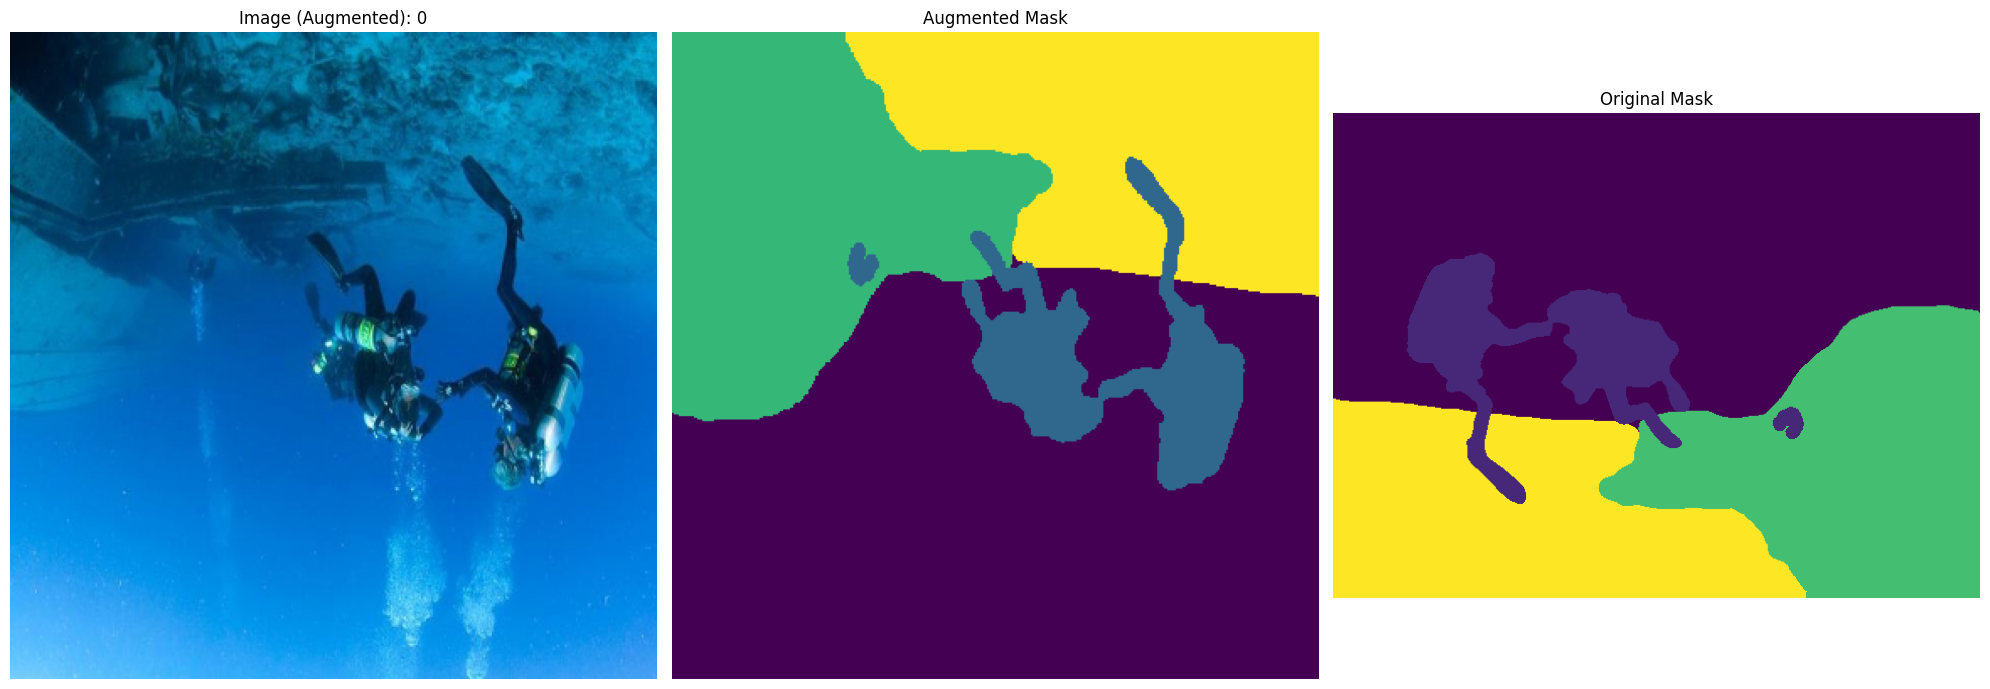

Unique classes in augmented mask: [0 1 2 3]


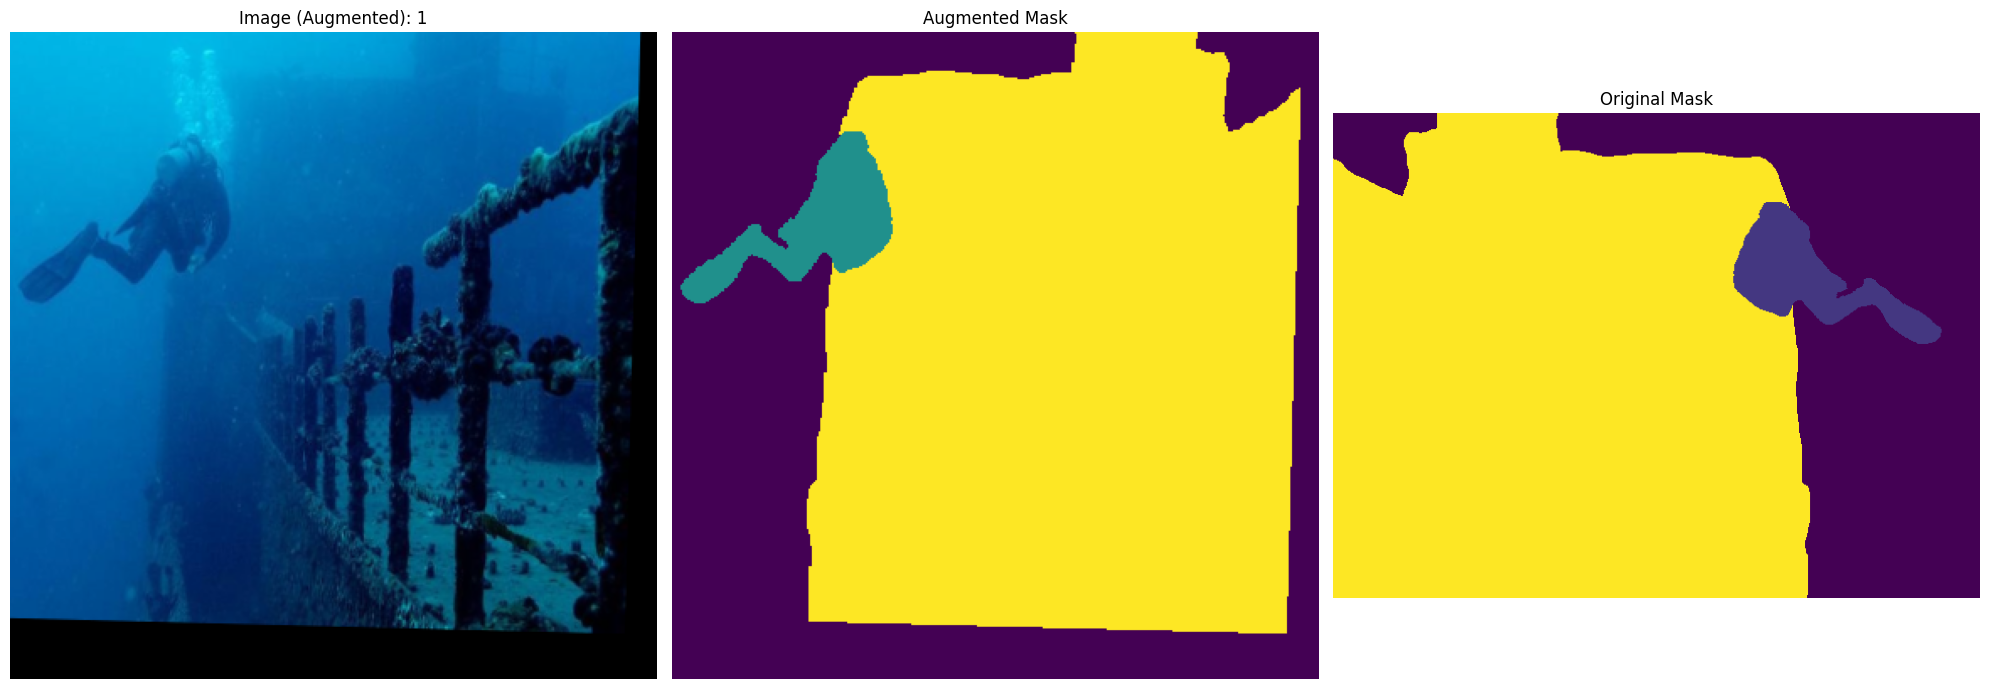

Unique classes in augmented mask: [0 1 2]


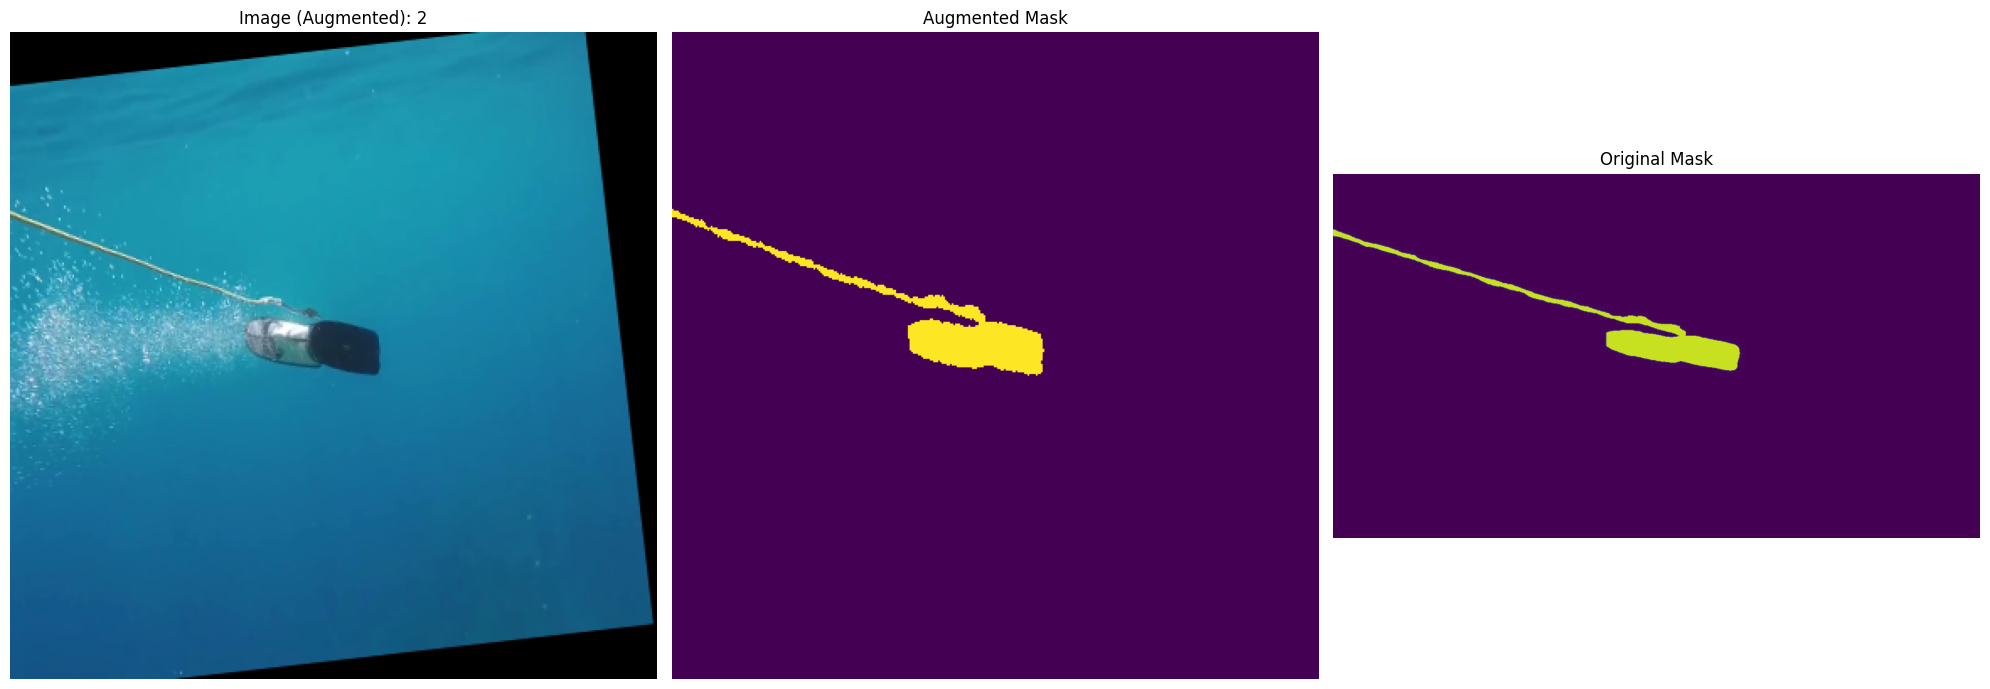

Unique classes in augmented mask: [0 4]


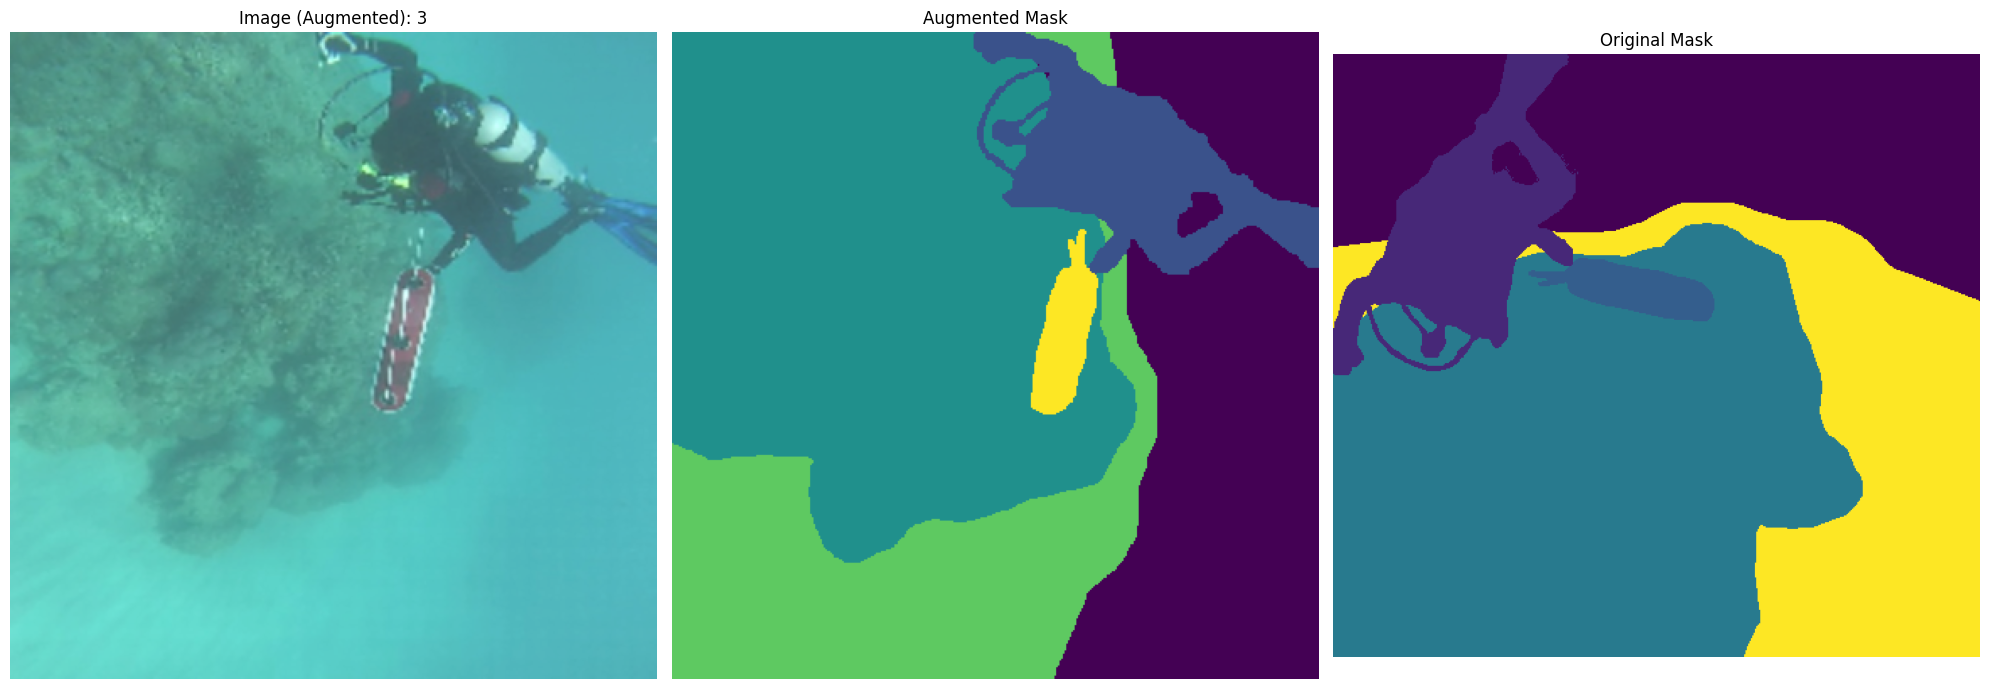

Unique classes in augmented mask: [0 1 2 3 4]


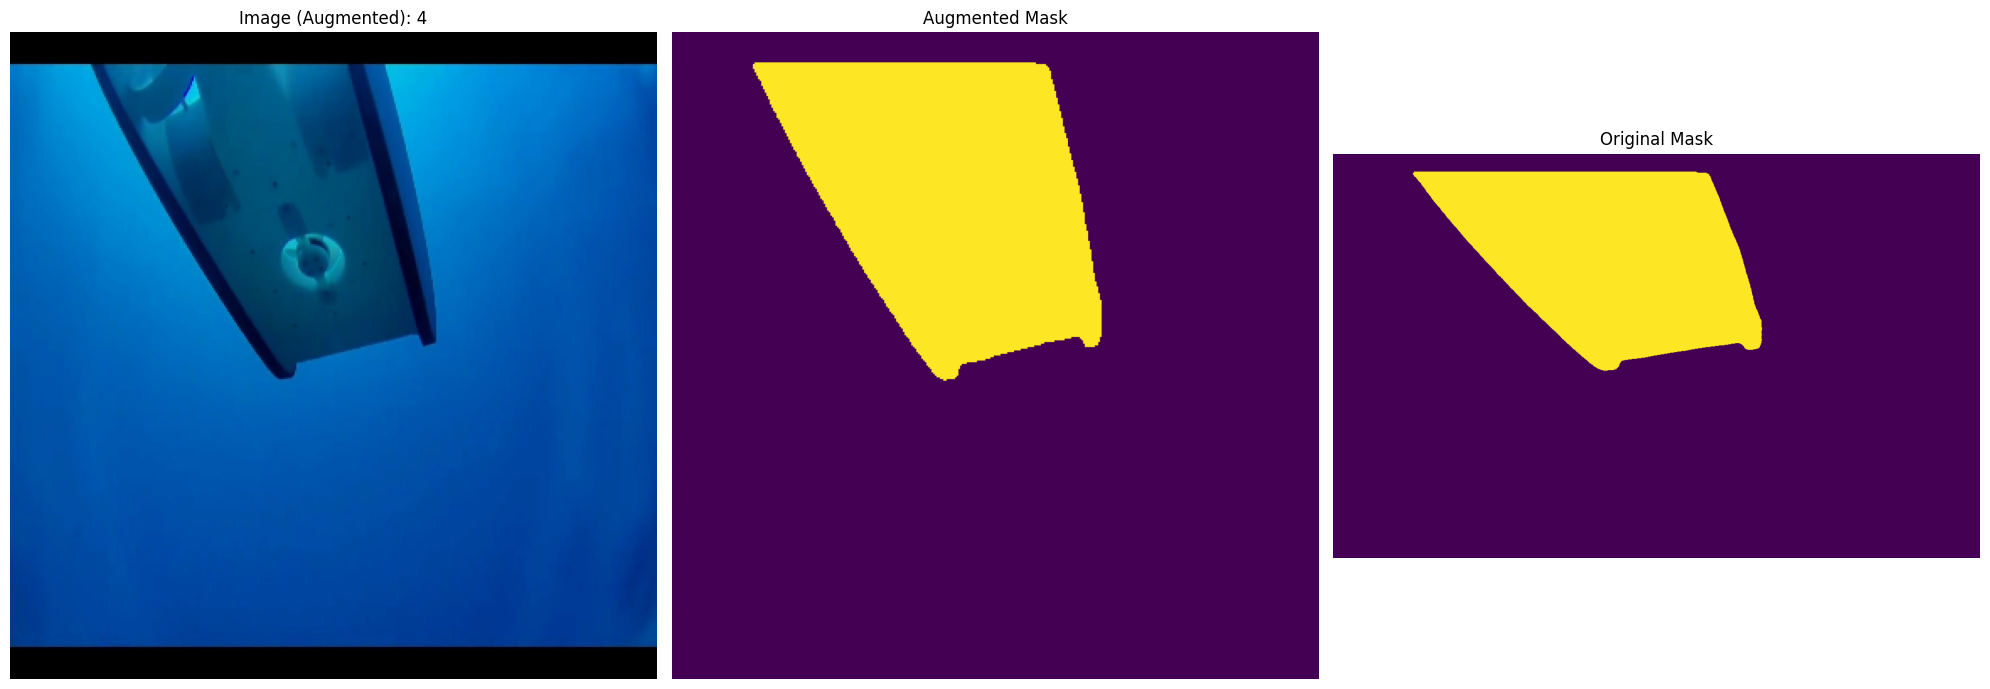

Unique classes in augmented mask: [0 4]


In [31]:
viz(train_dataset, mask_comparison_train, t = 5)

0 - фон (черный) 
4 - техника (голубой)
1 - люди (красный)
3 - пол (белый)
7 - растения 
5 - живность (розовый)
2 - рифы камни
6 - обломки (зеленый)

**ТЕПЕРЬ КОГДА МЕТКИ СОВПАДАЮТ МЕЖДУ ВЫБОРКАМИ**

In [32]:
import gc
import os
from PIL import Image


gc.collect()

126918

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader

def compute_class_weights_from_loader(
    loader: DataLoader,
    num_classes: int,
    ignore_index: int | None = None,
    eps: float = 1e-12,
):


    counts = np.zeros(num_classes, dtype=np.int64)
    total = 0

    for _, masks in loader:
        # masks: (B, H, W)
        masks = masks.view(-1)  # (B*H*W,)

        if ignore_index is not None:
            masks = masks[masks != ignore_index]

        if masks.numel() == 0:
            continue

        max_id = int(masks.max())
        if max_id >= num_classes:
            raise ValueError(
                f"Found class id {max_id} >= num_classes={num_classes}"
            )

        binc = torch.bincount(masks, minlength=num_classes)
        counts += binc.cpu().numpy()
        total += masks.numel()

    if total == 0:
        raise ValueError("No pixels counted. Check loader / ignore_index.")

    p = counts / (total + eps)

    weights = 1.0 / np.log(1.02 + p)
    weights = weights / weights.mean()

    return counts, p, weights

train_transform_for_stats = A.Compose([
    A.Resize(SIZE, SIZE), 
    ToTensorV2(),
], is_check_shapes=False) 

train_dataset_for_stats = SegmentationDataset("SUIM/train_val/images", "fixed_masks_train/final_masks", train_transform_for_stats, class_map = [0, 1, 2, 3, 4, 5, 2, 2] )

train_loader_for_stats = DataLoader(train_dataset_for_stats, 10, True)

counts, p, w = compute_class_weights_from_loader(
    train_loader_for_stats,
    num_classes=6,
    ignore_index=None   
)

In [34]:
print("counts:", counts)
print("p:", p)
print("weights:", w)

counts: [ 70088822   4232735 100347284  31659468    823667  17718424]
p: [0.31168541 0.018823   0.44624497 0.14078984 0.00366285 0.07879394]
weights: [0.22659876 1.70414795 0.16960379 0.43533114 2.77536824 0.68895011]


In [35]:
if torch.cuda.is_available:
    device = 'cuda'
else: 
    device == "cpu"
print(device)

cuda


In [36]:
weights = torch.tensor(
    w,
    dtype=torch.float32,
    device=device,  
)

criterion = nn.CrossEntropyLoss(weight=weights)  

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, groups=8):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(groups, out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False)
        self.gn2 = nn.GroupNorm(groups, out_ch)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False),
                nn.GroupNorm(groups, out_ch)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.gn1(self.conv1(x)))
        out = self.gn2(self.conv2(out))
        return self.relu(out + identity)

class MiniASPP(nn.Module):
    def __init__(self, in_ch, out_ch, rates=[2, 4, 8], groups=8):
        super().__init__()
        self.branches = nn.ModuleList([
            nn.Sequential(nn.Conv2d(in_ch, out_ch, 1, bias=False), nn.GroupNorm(groups, out_ch), nn.ReLU()),
            *[nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=r, dilation=r, bias=False),
                nn.GroupNorm(groups, out_ch),
                nn.ReLU()
            ) for r in rates]
        ])
        self.conv_out = nn.Conv2d(out_ch * (len(rates) + 1), out_ch, 1, bias=False)
        self.gn_out = nn.GroupNorm(groups, out_ch)
        self.dropout = nn.Dropout2d(0.2)

    def forward(self, x):
        res = torch.cat([br(x) for br in self.branches], dim=1)
        return self.dropout(self.gn_out(self.conv_out(res)))

class ResUNetSmall(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.enc0 = nn.Sequential(nn.Conv2d(3, 32, 3, padding=1), nn.GroupNorm(8, 32), nn.ReLU())
        self.enc1 = ResidualBlock(32, 64, stride=2)   
        self.enc2 = ResidualBlock(64, 128, stride=2)  
        self.enc3 = ResidualBlock(128, 256, stride=2) 
        
        self.bottleneck = MiniASPP(256, 512)
        
        self.up3 = nn.Conv2d(512, 256, 1)
        self.dec3 = ResidualBlock(512, 256) 
        
        self.up2 = nn.Conv2d(256, 128, 1)
        self.dec2 = ResidualBlock(256, 128) 
        
        self.up1 = nn.Conv2d(128, 64, 1)
        self.dec1 = ResidualBlock(128, 64)  
        
        self.up0 = nn.Conv2d(64, 32, 1)
        self.dec0 = ResidualBlock(64, 32)   
        
        self.head = nn.Conv2d(32, num_classes, 1)

    def forward(self, x):
        s0 = self.enc0(x)
        s1 = self.enc1(s0)
        s2 = self.enc2(s1)
        s3 = self.enc3(s2)
        
        b = self.bottleneck(s3)
        
        x = self.dec3(torch.cat([F.interpolate(self.up3(b), size=s3.shape[2:], mode='bilinear'), s3], dim=1))
        x = self.dec2(torch.cat([F.interpolate(self.up2(x), size=s2.shape[2:], mode='bilinear'), s2], dim=1))
        x = self.dec1(torch.cat([F.interpolate(self.up1(x), size=s1.shape[2:], mode='bilinear'), s1], dim=1))
        x = self.dec0(torch.cat([F.interpolate(self.up0(x), size=s0.shape[2:], mode='bilinear'), s0], dim=1))
        
        return self.head(x)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResUNetSmall(num_classes=6).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
scaler = torch.amp.GradScaler()

train_loss = []
val_loss = []

EPOCHS = 200
best_miou = -1.0

ckpt_dir = "checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)

for epoch in range(EPOCHS):

    model.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Train [{epoch+1}/{EPOCHS}]")
    for data, target in loop:
        data = data.to(device)
        target = target.long().to(device)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type="cuda"):
            outputs = model(data)
            loss = criterion(outputs, target)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    epoch_train_loss = running_loss / len(train_loader)
    train_loss.append(epoch_train_loss)

    model.eval()
    running_loss = 0.0
    ious = []

    with torch.no_grad():
        for data, target in tqdm(val_loader, desc="Validation"):
            data = data.to(device)
            target = target.long().to(device)

            outputs = model(data)
            loss = criterion(outputs, target)

            running_loss += loss.item()

            preds = outputs.argmax(dim=1)
            batch_ious = get_iou(preds, target, n_classes=6)
            ious.extend(batch_ious)

    epoch_val_loss = running_loss / len(val_loader)
    mean_iou = sum(ious) / len(ious) if len(ious) > 0 else 0.0

    val_loss.append((
        float(epoch_val_loss),
        float(mean_iou)
    ))

    scheduler.step()

    if mean_iou > best_miou:
        best_miou = mean_iou

        ckpt_path = os.path.join(
            ckpt_dir,
            f"resunet_best_miou_{best_miou:.4f}.pt"
        )

        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
                "best_miou": best_miou,
                "num_classes": 6,
            },
            ckpt_path
        )

        print(f"New best mIoU: {best_miou:.4f}, checkpoint saved")

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {epoch_train_loss:.4f} | "
        f"Val Loss: {epoch_val_loss:.4f} | "
        f"mIoU: {mean_iou:.4f}"
    )


Validation: 100%|██████████| 22/22 [00:03<00:00,  6.86it/s]


New best mIoU: 0.2535, checkpoint saved
Epoch 01 | Train Loss: 1.0826 | Val Loss: 0.9944 | mIoU: 0.2535


Validation: 100%|██████████| 22/22 [00:03<00:00,  6.75it/s]


New best mIoU: 0.3034, checkpoint saved
Epoch 02 | Train Loss: 0.9228 | Val Loss: 0.8687 | mIoU: 0.3034


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.02it/s]


Epoch 03 | Train Loss: 0.8690 | Val Loss: 0.8800 | mIoU: 0.2883


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.01it/s]


Epoch 04 | Train Loss: 0.8297 | Val Loss: 0.9179 | mIoU: 0.2632


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.14it/s]


New best mIoU: 0.3477, checkpoint saved
Epoch 05 | Train Loss: 0.8092 | Val Loss: 0.8277 | mIoU: 0.3477


Validation: 100%|██████████| 22/22 [00:03<00:00,  6.73it/s]


New best mIoU: 0.3561, checkpoint saved
Epoch 06 | Train Loss: 0.7783 | Val Loss: 0.7859 | mIoU: 0.3561


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s]


New best mIoU: 0.3900, checkpoint saved
Epoch 07 | Train Loss: 0.7595 | Val Loss: 0.7131 | mIoU: 0.3900


Validation: 100%|██████████| 22/22 [00:03<00:00,  6.80it/s]


Epoch 08 | Train Loss: 0.7392 | Val Loss: 0.7117 | mIoU: 0.3838


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


Epoch 09 | Train Loss: 0.7195 | Val Loss: 0.7040 | mIoU: 0.3650


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.19it/s]


New best mIoU: 0.3975, checkpoint saved
Epoch 10 | Train Loss: 0.7196 | Val Loss: 0.6884 | mIoU: 0.3975


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.08it/s]


Epoch 11 | Train Loss: 0.6973 | Val Loss: 0.7198 | mIoU: 0.3570


Validation: 100%|██████████| 22/22 [00:03<00:00,  6.99it/s]


Epoch 12 | Train Loss: 0.6833 | Val Loss: 0.7114 | mIoU: 0.3705


Validation: 100%|██████████| 22/22 [00:04<00:00,  5.16it/s]


Epoch 13 | Train Loss: 0.6861 | Val Loss: 0.6648 | mIoU: 0.3870


Validation: 100%|██████████| 22/22 [00:03<00:00,  6.89it/s]


Epoch 14 | Train Loss: 0.6682 | Val Loss: 0.6786 | mIoU: 0.3809


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.12it/s]


Epoch 15 | Train Loss: 0.6514 | Val Loss: 0.6595 | mIoU: 0.3969


Validation: 100%|██████████| 22/22 [00:03<00:00,  6.91it/s]


Epoch 16 | Train Loss: 0.6516 | Val Loss: 0.7079 | mIoU: 0.3646


Validation: 100%|██████████| 22/22 [00:03<00:00,  6.64it/s]


Epoch 17 | Train Loss: 0.6351 | Val Loss: 0.6552 | mIoU: 0.3944


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.21it/s]


Epoch 18 | Train Loss: 0.6337 | Val Loss: 0.6894 | mIoU: 0.3770


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.11it/s]


Epoch 19 | Train Loss: 0.6375 | Val Loss: 0.6600 | mIoU: 0.3910


Validation: 100%|██████████| 22/22 [00:03<00:00,  6.45it/s]


New best mIoU: 0.4036, checkpoint saved
Epoch 20 | Train Loss: 0.6173 | Val Loss: 0.6272 | mIoU: 0.4036


Validation: 100%|██████████| 22/22 [00:03<00:00,  6.91it/s]


Epoch 21 | Train Loss: 0.6144 | Val Loss: 0.6694 | mIoU: 0.4011


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.15it/s]


New best mIoU: 0.4146, checkpoint saved
Epoch 22 | Train Loss: 0.6062 | Val Loss: 0.6293 | mIoU: 0.4146


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.09it/s]


New best mIoU: 0.4300, checkpoint saved
Epoch 23 | Train Loss: 0.6135 | Val Loss: 0.5946 | mIoU: 0.4300


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.02it/s]


Epoch 24 | Train Loss: 0.5959 | Val Loss: 0.6163 | mIoU: 0.4194


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.20it/s]


Epoch 25 | Train Loss: 0.5827 | Val Loss: 0.5977 | mIoU: 0.4179


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


New best mIoU: 0.4323, checkpoint saved
Epoch 26 | Train Loss: 0.5879 | Val Loss: 0.6004 | mIoU: 0.4323


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s]


Epoch 27 | Train Loss: 0.5839 | Val Loss: 0.6254 | mIoU: 0.4136


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.19it/s]


Epoch 28 | Train Loss: 0.5764 | Val Loss: 0.6442 | mIoU: 0.4081


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.06it/s]


Epoch 29 | Train Loss: 0.5780 | Val Loss: 0.6066 | mIoU: 0.4236


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.15it/s]


Epoch 30 | Train Loss: 0.5744 | Val Loss: 0.5798 | mIoU: 0.4169


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.12it/s]


Epoch 31 | Train Loss: 0.5596 | Val Loss: 0.6401 | mIoU: 0.3862


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.22it/s]


New best mIoU: 0.4350, checkpoint saved
Epoch 32 | Train Loss: 0.5646 | Val Loss: 0.5911 | mIoU: 0.4350


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


Epoch 33 | Train Loss: 0.5519 | Val Loss: 0.5925 | mIoU: 0.4211


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.21it/s]


Epoch 34 | Train Loss: 0.5482 | Val Loss: 0.5798 | mIoU: 0.4275


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.21it/s]


Epoch 35 | Train Loss: 0.5529 | Val Loss: 0.5912 | mIoU: 0.4190


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.19it/s]


Epoch 36 | Train Loss: 0.5511 | Val Loss: 0.5885 | mIoU: 0.4188


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.16it/s]


Epoch 37 | Train Loss: 0.5366 | Val Loss: 0.6518 | mIoU: 0.4023


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s]


Epoch 38 | Train Loss: 0.5297 | Val Loss: 0.6502 | mIoU: 0.4011


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


Epoch 39 | Train Loss: 0.5448 | Val Loss: 0.6001 | mIoU: 0.4101


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.20it/s]


Epoch 40 | Train Loss: 0.5310 | Val Loss: 0.5986 | mIoU: 0.4147


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


Epoch 41 | Train Loss: 0.5195 | Val Loss: 0.5920 | mIoU: 0.4248


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.24it/s]


New best mIoU: 0.4370, checkpoint saved
Epoch 42 | Train Loss: 0.5166 | Val Loss: 0.5929 | mIoU: 0.4370


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.20it/s]


Epoch 43 | Train Loss: 0.5206 | Val Loss: 0.5804 | mIoU: 0.4349


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.19it/s]


New best mIoU: 0.4467, checkpoint saved
Epoch 44 | Train Loss: 0.5046 | Val Loss: 0.5637 | mIoU: 0.4467


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s]


New best mIoU: 0.4545, checkpoint saved
Epoch 45 | Train Loss: 0.5005 | Val Loss: 0.5560 | mIoU: 0.4545


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.16it/s]


Epoch 46 | Train Loss: 0.5000 | Val Loss: 0.5824 | mIoU: 0.4356


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.23it/s]


Epoch 47 | Train Loss: 0.5073 | Val Loss: 0.5985 | mIoU: 0.4391


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


New best mIoU: 0.4683, checkpoint saved
Epoch 48 | Train Loss: 0.4982 | Val Loss: 0.5590 | mIoU: 0.4683


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.10it/s]


Epoch 49 | Train Loss: 0.4907 | Val Loss: 0.6070 | mIoU: 0.4468


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.15it/s]


Epoch 50 | Train Loss: 0.4871 | Val Loss: 0.5873 | mIoU: 0.4346


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s]


Epoch 51 | Train Loss: 0.4799 | Val Loss: 0.5754 | mIoU: 0.4468


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.21it/s]


Epoch 52 | Train Loss: 0.4736 | Val Loss: 0.5580 | mIoU: 0.4562


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s]


Epoch 53 | Train Loss: 0.4705 | Val Loss: 0.5416 | mIoU: 0.4582


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.11it/s]


Epoch 54 | Train Loss: 0.4683 | Val Loss: 0.5929 | mIoU: 0.4328


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.16it/s]


Epoch 55 | Train Loss: 0.4630 | Val Loss: 0.5858 | mIoU: 0.4312


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.07it/s]


Epoch 56 | Train Loss: 0.4649 | Val Loss: 0.5723 | mIoU: 0.4393


Validation: 100%|██████████| 22/22 [00:03<00:00,  6.83it/s]


Epoch 57 | Train Loss: 0.4705 | Val Loss: 0.5667 | mIoU: 0.4495


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.13it/s]


New best mIoU: 0.4715, checkpoint saved
Epoch 58 | Train Loss: 0.4513 | Val Loss: 0.5335 | mIoU: 0.4715


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.01it/s]


Epoch 59 | Train Loss: 0.4578 | Val Loss: 0.5524 | mIoU: 0.4539


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.12it/s]


Epoch 60 | Train Loss: 0.4391 | Val Loss: 0.5565 | mIoU: 0.4461


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.05it/s]


Epoch 61 | Train Loss: 0.4513 | Val Loss: 0.5298 | mIoU: 0.4621


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.15it/s]


Epoch 62 | Train Loss: 0.4429 | Val Loss: 0.5493 | mIoU: 0.4648


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.09it/s]


Epoch 63 | Train Loss: 0.4436 | Val Loss: 0.5532 | mIoU: 0.4584


Validation: 100%|██████████| 22/22 [00:03<00:00,  6.96it/s]


Epoch 64 | Train Loss: 0.4263 | Val Loss: 0.5333 | mIoU: 0.4707


Validation: 100%|██████████| 22/22 [00:03<00:00,  6.60it/s]


Epoch 65 | Train Loss: 0.4284 | Val Loss: 0.5452 | mIoU: 0.4632


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.15it/s]


Epoch 66 | Train Loss: 0.4281 | Val Loss: 0.5614 | mIoU: 0.4494


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s]


Epoch 67 | Train Loss: 0.4124 | Val Loss: 0.5872 | mIoU: 0.4371


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.19it/s]


Epoch 68 | Train Loss: 0.4217 | Val Loss: 0.5754 | mIoU: 0.4562


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.14it/s]


Epoch 69 | Train Loss: 0.4187 | Val Loss: 0.5566 | mIoU: 0.4568


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.23it/s]


Epoch 70 | Train Loss: 0.4113 | Val Loss: 0.5646 | mIoU: 0.4673


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s]


New best mIoU: 0.4738, checkpoint saved
Epoch 71 | Train Loss: 0.4149 | Val Loss: 0.5527 | mIoU: 0.4738


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.10it/s]


Epoch 72 | Train Loss: 0.3960 | Val Loss: 0.5356 | mIoU: 0.4539


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.20it/s]


Epoch 73 | Train Loss: 0.4091 | Val Loss: 0.5596 | mIoU: 0.4405


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.20it/s]


New best mIoU: 0.4915, checkpoint saved
Epoch 74 | Train Loss: 0.4049 | Val Loss: 0.5293 | mIoU: 0.4915


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.21it/s]


Epoch 75 | Train Loss: 0.3989 | Val Loss: 0.5498 | mIoU: 0.4785


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.19it/s]


Epoch 76 | Train Loss: 0.3906 | Val Loss: 0.5608 | mIoU: 0.4695


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.15it/s]


Epoch 77 | Train Loss: 0.4050 | Val Loss: 0.5523 | mIoU: 0.4609


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.21it/s]


Epoch 78 | Train Loss: 0.3885 | Val Loss: 0.5653 | mIoU: 0.4708


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


Epoch 79 | Train Loss: 0.3938 | Val Loss: 0.5970 | mIoU: 0.4528


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.22it/s]


Epoch 80 | Train Loss: 0.3826 | Val Loss: 0.5587 | mIoU: 0.4609


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.13it/s]


Epoch 81 | Train Loss: 0.3949 | Val Loss: 0.6134 | mIoU: 0.4487


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s]


Epoch 82 | Train Loss: 0.3785 | Val Loss: 0.5704 | mIoU: 0.4687


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


Epoch 83 | Train Loss: 0.3835 | Val Loss: 0.5623 | mIoU: 0.4564


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.23it/s]


Epoch 84 | Train Loss: 0.3787 | Val Loss: 0.5838 | mIoU: 0.4615


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.10it/s]


Epoch 85 | Train Loss: 0.3695 | Val Loss: 0.5616 | mIoU: 0.4729


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s]


Epoch 86 | Train Loss: 0.3621 | Val Loss: 0.5591 | mIoU: 0.4884


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.21it/s]


Epoch 87 | Train Loss: 0.3598 | Val Loss: 0.5851 | mIoU: 0.4664


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.20it/s]


Epoch 88 | Train Loss: 0.3673 | Val Loss: 0.5755 | mIoU: 0.4757


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s]


Epoch 89 | Train Loss: 0.3649 | Val Loss: 0.5903 | mIoU: 0.4513


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.23it/s]


Epoch 90 | Train Loss: 0.3645 | Val Loss: 0.5709 | mIoU: 0.4747


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.16it/s]


Epoch 91 | Train Loss: 0.3549 | Val Loss: 0.5484 | mIoU: 0.4593


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.19it/s]


Epoch 92 | Train Loss: 0.3527 | Val Loss: 0.5543 | mIoU: 0.4712


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.07it/s]


Epoch 93 | Train Loss: 0.3497 | Val Loss: 0.5873 | mIoU: 0.4739


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.13it/s]


Epoch 94 | Train Loss: 0.3471 | Val Loss: 0.5787 | mIoU: 0.4869


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


Epoch 95 | Train Loss: 0.3391 | Val Loss: 0.5768 | mIoU: 0.4898


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.12it/s]


Epoch 96 | Train Loss: 0.3427 | Val Loss: 0.5496 | mIoU: 0.4829


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


Epoch 97 | Train Loss: 0.3448 | Val Loss: 0.5464 | mIoU: 0.4799


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.14it/s]


Epoch 98 | Train Loss: 0.3347 | Val Loss: 0.6244 | mIoU: 0.4597


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s]


Epoch 99 | Train Loss: 0.3308 | Val Loss: 0.5443 | mIoU: 0.4730


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.20it/s]


New best mIoU: 0.5072, checkpoint saved
Epoch 100 | Train Loss: 0.3347 | Val Loss: 0.5346 | mIoU: 0.5072


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.23it/s]


Epoch 101 | Train Loss: 0.3267 | Val Loss: 0.5469 | mIoU: 0.4993


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.13it/s]


Epoch 102 | Train Loss: 0.3179 | Val Loss: 0.5739 | mIoU: 0.4763


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s]


Epoch 103 | Train Loss: 0.3231 | Val Loss: 0.5795 | mIoU: 0.4759


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.15it/s]


Epoch 104 | Train Loss: 0.3169 | Val Loss: 0.5594 | mIoU: 0.4740


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.16it/s]


Epoch 105 | Train Loss: 0.3223 | Val Loss: 0.5764 | mIoU: 0.4870


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.12it/s]


Epoch 106 | Train Loss: 0.3168 | Val Loss: 0.5765 | mIoU: 0.4690


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s]


Epoch 107 | Train Loss: 0.3158 | Val Loss: 0.5433 | mIoU: 0.4878


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s]


Epoch 108 | Train Loss: 0.3143 | Val Loss: 0.5580 | mIoU: 0.4879


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


Epoch 109 | Train Loss: 0.3112 | Val Loss: 0.5724 | mIoU: 0.4824


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.13it/s]


Epoch 110 | Train Loss: 0.3063 | Val Loss: 0.5615 | mIoU: 0.4754


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s]


Epoch 111 | Train Loss: 0.3040 | Val Loss: 0.5966 | mIoU: 0.4872


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


Epoch 112 | Train Loss: 0.3089 | Val Loss: 0.5376 | mIoU: 0.4801


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.20it/s]


Epoch 113 | Train Loss: 0.3007 | Val Loss: 0.5687 | mIoU: 0.4901


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.15it/s]


Epoch 114 | Train Loss: 0.3049 | Val Loss: 0.5737 | mIoU: 0.4831


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.19it/s]


Epoch 115 | Train Loss: 0.2939 | Val Loss: 0.5570 | mIoU: 0.5038


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


Epoch 116 | Train Loss: 0.2921 | Val Loss: 0.5341 | mIoU: 0.4861


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.23it/s]


Epoch 117 | Train Loss: 0.2972 | Val Loss: 0.5805 | mIoU: 0.4788


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.22it/s]


Epoch 118 | Train Loss: 0.3028 | Val Loss: 0.5711 | mIoU: 0.4865


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.20it/s]


Epoch 119 | Train Loss: 0.2823 | Val Loss: 0.5855 | mIoU: 0.4648


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s]


Epoch 120 | Train Loss: 0.2856 | Val Loss: 0.5675 | mIoU: 0.4990


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


Epoch 121 | Train Loss: 0.2825 | Val Loss: 0.6061 | mIoU: 0.4735


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.23it/s]


Epoch 122 | Train Loss: 0.2911 | Val Loss: 0.5387 | mIoU: 0.4919


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.22it/s]


Epoch 123 | Train Loss: 0.2811 | Val Loss: 0.5350 | mIoU: 0.4874


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.07it/s]


Epoch 124 | Train Loss: 0.2772 | Val Loss: 0.5854 | mIoU: 0.4745


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.13it/s]


Epoch 125 | Train Loss: 0.2810 | Val Loss: 0.5780 | mIoU: 0.4830


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.24it/s]


Epoch 126 | Train Loss: 0.2756 | Val Loss: 0.5636 | mIoU: 0.4876


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.12it/s]


Epoch 127 | Train Loss: 0.2729 | Val Loss: 0.5545 | mIoU: 0.5001


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.19it/s]


Epoch 128 | Train Loss: 0.2801 | Val Loss: 0.5719 | mIoU: 0.4847


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.16it/s]


Epoch 129 | Train Loss: 0.2675 | Val Loss: 0.5739 | mIoU: 0.5016


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.22it/s]


Epoch 130 | Train Loss: 0.2718 | Val Loss: 0.5626 | mIoU: 0.4941


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.14it/s]


Epoch 131 | Train Loss: 0.2770 | Val Loss: 0.5577 | mIoU: 0.5053


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.19it/s]


Epoch 132 | Train Loss: 0.2686 | Val Loss: 0.5385 | mIoU: 0.5018


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.20it/s]


Epoch 133 | Train Loss: 0.2689 | Val Loss: 0.5614 | mIoU: 0.4937


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.23it/s]


Epoch 134 | Train Loss: 0.2621 | Val Loss: 0.5607 | mIoU: 0.4948


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


Epoch 135 | Train Loss: 0.2568 | Val Loss: 0.5739 | mIoU: 0.4966


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.20it/s]


Epoch 136 | Train Loss: 0.2522 | Val Loss: 0.5928 | mIoU: 0.4862


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s]


Epoch 137 | Train Loss: 0.2547 | Val Loss: 0.5697 | mIoU: 0.5017


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


Epoch 138 | Train Loss: 0.2508 | Val Loss: 0.5947 | mIoU: 0.4976


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.22it/s]


Epoch 139 | Train Loss: 0.2581 | Val Loss: 0.5780 | mIoU: 0.4960


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.14it/s]


Epoch 140 | Train Loss: 0.2588 | Val Loss: 0.5981 | mIoU: 0.4973


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s]


Epoch 141 | Train Loss: 0.2528 | Val Loss: 0.6041 | mIoU: 0.4923


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


Epoch 142 | Train Loss: 0.2555 | Val Loss: 0.5944 | mIoU: 0.4984


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.15it/s]


Epoch 143 | Train Loss: 0.2512 | Val Loss: 0.5719 | mIoU: 0.5016


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.19it/s]


Epoch 144 | Train Loss: 0.2481 | Val Loss: 0.5535 | mIoU: 0.5042


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.19it/s]


Epoch 145 | Train Loss: 0.2522 | Val Loss: 0.5638 | mIoU: 0.5032


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.23it/s]


Epoch 146 | Train Loss: 0.2477 | Val Loss: 0.5978 | mIoU: 0.4902


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.20it/s]


Epoch 147 | Train Loss: 0.2481 | Val Loss: 0.5936 | mIoU: 0.4897


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.13it/s]


Epoch 148 | Train Loss: 0.2516 | Val Loss: 0.5946 | mIoU: 0.4960


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.19it/s]


Epoch 149 | Train Loss: 0.2392 | Val Loss: 0.5624 | mIoU: 0.5002


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.22it/s]


Epoch 150 | Train Loss: 0.2379 | Val Loss: 0.5870 | mIoU: 0.5006


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.14it/s]


Epoch 151 | Train Loss: 0.2396 | Val Loss: 0.5936 | mIoU: 0.4997


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.11it/s]


Epoch 152 | Train Loss: 0.2401 | Val Loss: 0.5820 | mIoU: 0.5012


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.16it/s]


Epoch 153 | Train Loss: 0.2415 | Val Loss: 0.5944 | mIoU: 0.5027


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.14it/s]


Epoch 154 | Train Loss: 0.2364 | Val Loss: 0.6078 | mIoU: 0.5038


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.24it/s]


Epoch 155 | Train Loss: 0.2374 | Val Loss: 0.6293 | mIoU: 0.4945


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.23it/s]


Epoch 156 | Train Loss: 0.2383 | Val Loss: 0.6061 | mIoU: 0.4914


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s]


Epoch 157 | Train Loss: 0.2355 | Val Loss: 0.5908 | mIoU: 0.4928


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


Epoch 158 | Train Loss: 0.2325 | Val Loss: 0.5995 | mIoU: 0.4907


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.22it/s]


Epoch 159 | Train Loss: 0.2328 | Val Loss: 0.5888 | mIoU: 0.4982


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.09it/s]


New best mIoU: 0.5125, checkpoint saved
Epoch 160 | Train Loss: 0.2358 | Val Loss: 0.5851 | mIoU: 0.5125


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.16it/s]


Epoch 161 | Train Loss: 0.2253 | Val Loss: 0.5838 | mIoU: 0.5077


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.21it/s]


Epoch 162 | Train Loss: 0.2301 | Val Loss: 0.5829 | mIoU: 0.5017


Validation: 100%|██████████| 22/22 [00:03<00:00,  7.23it/s]


Epoch 163 | Train Loss: 0.2265 | Val Loss: 0.5851 | mIoU: 0.4978


Train [164/200]:  33%|███▎      | 51/153 [00:28<00:57,  1.76it/s, loss=0.202]


KeyboardInterrupt: 

In [39]:
import matplotlib.pyplot as plt
import math

def plot_val_loss_iou(val_loss, title="Validation Loss & Mean IoU"):
    if len(val_loss) < 2:
        print("Nothing to plot, val_loss length:", len(val_loss))
        return

    def to_float(x):
        if hasattr(x, "detach"):
            return float(x.detach().cpu())
        return float(x)

    losses = [to_float(x[0]) for x in val_loss]
    ious   = [to_float(x[1]) for x in val_loss]

    if any(math.isnan(x) or math.isinf(x) for x in losses + ious):
        print("NaN or Inf detected, skipping plot")
        return

    epochs = range(1, len(val_loss) + 1)

    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(epochs, losses, marker="o", label="Val Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True, linestyle="--", alpha=0.4)

    ax2 = ax1.twinx()
    ax2.plot(epochs, ious, marker="o", linestyle="--", label="Mean IoU")
    ax2.set_ylabel("mIoU")

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2)

    plt.title(title)
    plt.tight_layout()
    plt.show()


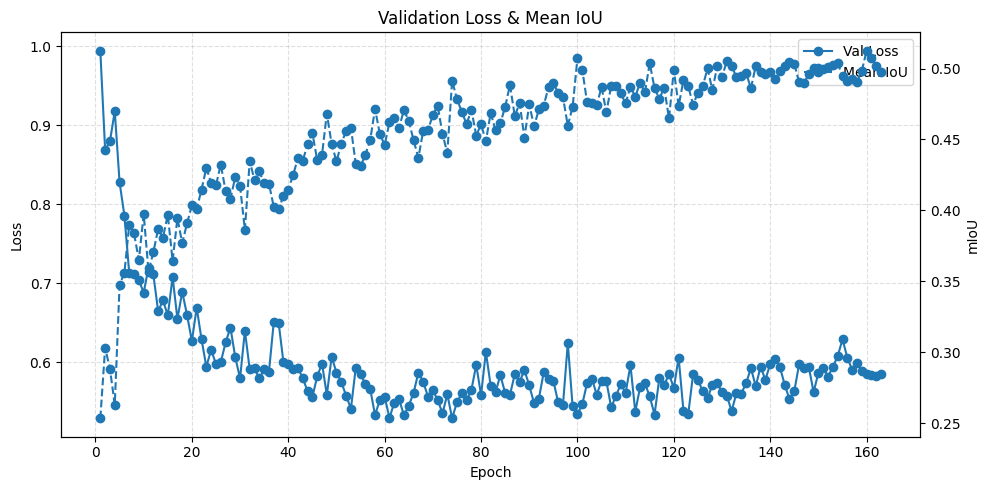

In [40]:
plot_val_loss_iou(val_loss)

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, num_classes, smooth=1e-5, ignore_index=None):
        super().__init__()
        self.num_classes = num_classes
        self.smooth = smooth
        self.ignore_index = ignore_index

    def forward(self, logits, targets):
        """
        logits  : (B, C, H, W)
        targets : (B, H, W) long
        """

        probs = F.softmax(logits, dim=1)  

        targets_oh = F.one_hot(targets, self.num_classes)  
        targets_oh = targets_oh.permute(0, 3, 1, 2).float()

        if self.ignore_index is not None:
            mask = (targets != self.ignore_index).unsqueeze(1)
            probs = probs * mask
            targets_oh = targets_oh * mask

        dims = (0, 2, 3)  

        intersection = torch.sum(probs * targets_oh, dims)
        union = torch.sum(probs, dims) + torch.sum(targets_oh, dims)

        dice = (2. * intersection + self.smooth) / (union + self.smooth)

        return 1.0 - dice.mean()


In [ ]:
import torch
import matplotlib.pyplot as plt
import random
import numpy as np

@torch.no_grad()
def visualize_predictions_with_errors(
    model,
    dataset,
    device,
    num_samples=10,
    num_classes=6
):


    model.eval()
    idxs = random.sample(range(len(dataset)), num_samples)

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))
    if num_samples == 1:
        axes = axes[None, :]

    for row, idx in enumerate(idxs):
        img, gt_mask = dataset[idx]

        img_t = img.unsqueeze(0).to(device)
        pred = model(img_t)
        pred_mask = pred.argmax(dim=1).squeeze(0)

        img_np = img.permute(1, 2, 0).cpu().numpy()
        gt_np  = gt_mask.cpu().numpy()
        pr_np  = pred_mask.cpu().numpy()

        error = (pr_np != gt_np)

        error_rgb = np.zeros((*error.shape, 3), dtype=np.uint8)
        error_rgb[error] = [255, 0, 0]

        axes[row, 0].imshow(img_np)
        axes[row, 0].set_title("Image")
        axes[row, 0].axis("off")

        axes[row, 1].imshow(gt_np, cmap="tab20",
                            vmin=0, vmax=(num_classes - 1) if num_classes else None)
        axes[row, 1].set_title("Ground Truth")
        axes[row, 1].axis("off")

        axes[row, 2].imshow(pr_np, cmap="tab20",
                            vmin=0, vmax=(num_classes - 1) if num_classes else None)
        axes[row, 2].set_title("Prediction")
        axes[row, 2].axis("off")

        axes[row, 3].imshow(error_rgb)
        axes[row, 3].set_title("Errors (red = mismatch)")
        axes[row, 3].axis("off")

    plt.tight_layout()
    plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.3437037].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2216992].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2

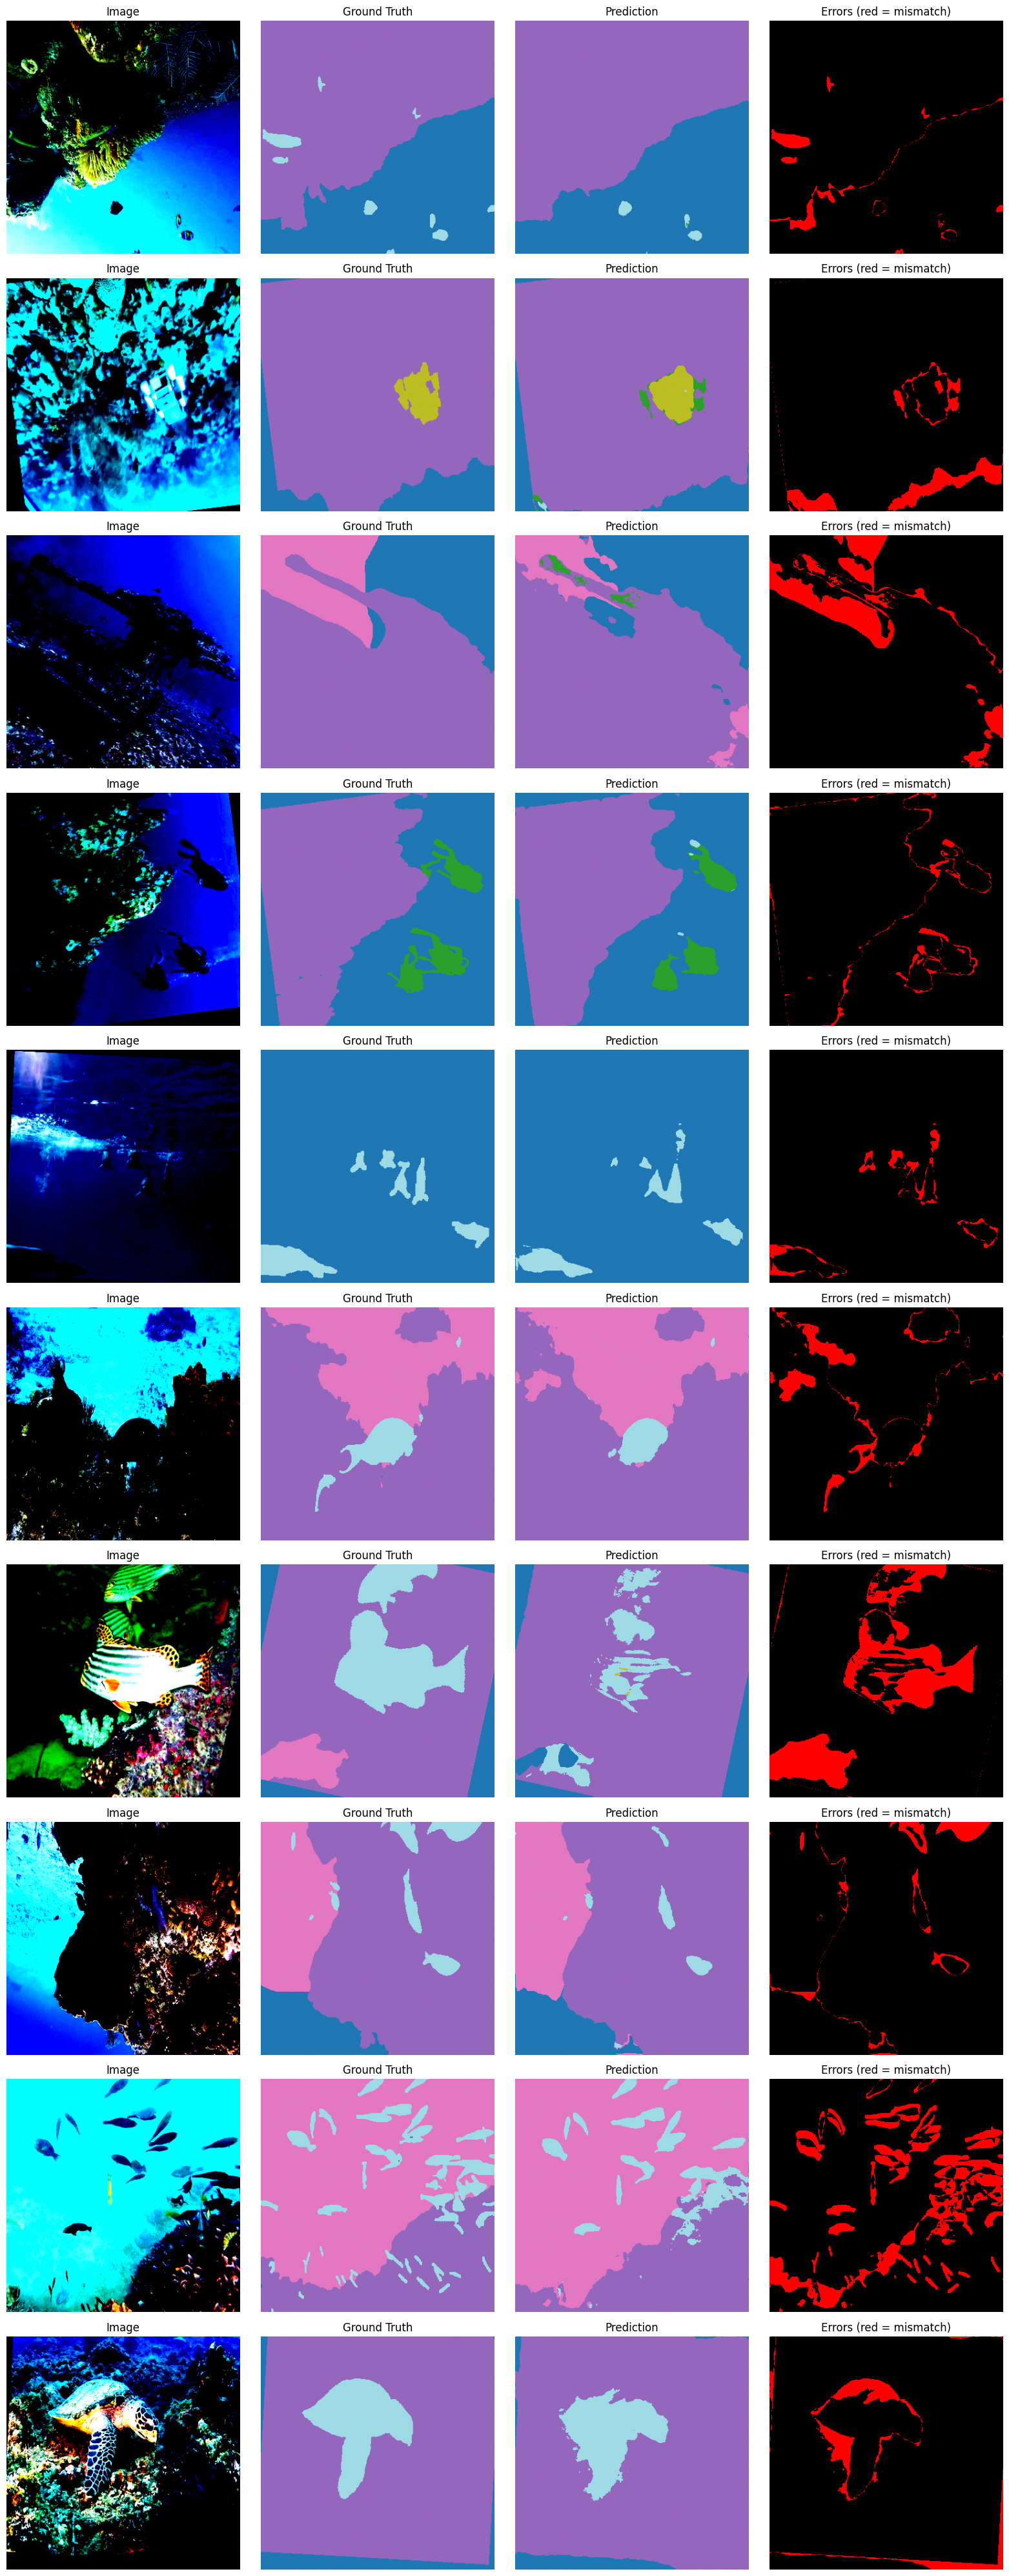

In [ ]:
visualize_predictions_with_errors(
    model=model,
    dataset=val_dataset,
    device=device,
    num_samples=10,
    num_classes=6
)



In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

@torch.no_grad()
def plot_confusion_matrix_sklearn(
    model,
    loader,
    num_classes: int,
    device,
    class_names=None,
    ignore_index: int | None = None,
    normalize: str = "true",  
):


    model.eval()
    all_preds = []
    all_targets = []

    for images, targets in tqdm(loader, desc="Confusion matrix"):
        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        preds = preds.view(-1).cpu().numpy()
        targets = targets.view(-1).cpu().numpy()

        if ignore_index is not None:
            mask = targets != ignore_index
            preds = preds[mask]
            targets = targets[mask]

        all_preds.append(preds)
        all_targets.append(targets)

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_targets)

    cm = confusion_matrix(
        y_true,
        y_pred,
        labels=np.arange(num_classes),
        normalize=normalize
    )

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=class_names if class_names else np.arange(num_classes)
    )

    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(
        ax=ax,
        cmap="Blues",
        values_format=".2f" if normalize else "d",
        colorbar=True
    )

    plt.title(
        "Normalized Confusion Matrix (GT)"
        if normalize == "true"
        else "Confusion Matrix"
    )
    plt.tight_layout()
    plt.show()

    return cm




Confusion matrix: 100%|██████████| 22/22 [00:03<00:00,  6.24it/s]


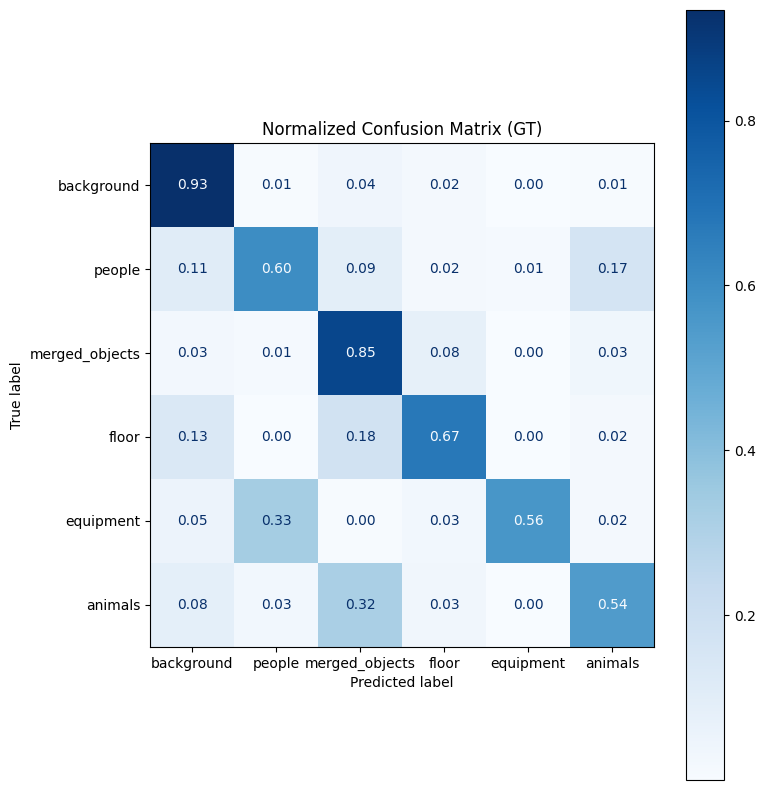

array([[9.34171566e-01, 5.65385273e-03, 3.69394653e-02, 1.75900025e-02,
        1.57915999e-04, 5.48719769e-03],
       [1.06485564e-01, 5.98516720e-01, 9.34205736e-02, 2.09275554e-02,
        1.40099292e-02, 1.66639658e-01],
       [2.52543351e-02, 1.26740931e-02, 8.51807504e-01, 7.70125470e-02,
        4.37169078e-05, 3.32078043e-02],
       [1.33224871e-01, 4.54447682e-04, 1.78576810e-01, 6.71556251e-01,
        5.85378492e-05, 1.61290825e-02],
       [5.34889375e-02, 3.30299052e-01, 3.90955507e-03, 2.89326526e-02,
        5.62703623e-01, 2.06661804e-02],
       [8.48790635e-02, 2.64833271e-02, 3.15811269e-01, 3.03819939e-02,
        1.62029811e-03, 5.40824049e-01]])

In [46]:
class_names = [
    "background",
    "people",
    "merged_objects",
    "floor",
    "equipment",
    "animals"
]

plot_confusion_matrix_sklearn(
    model=model,
    loader=val_loader,
    num_classes=6,
    device=device,
    class_names=class_names,
    normalize="true"  
)




In [62]:
import torch
import torch.nn as nn
import torch.optim as optim

ckpt_path = "checkpoints/resunet_best_miou_0.5125.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt = torch.load(ckpt_path, map_location=device)

print(f"Loaded checkpoint from epoch {ckpt['epoch']}, "
      f"best mIoU = {ckpt['best_miou']:.4f}")


Loaded checkpoint from epoch 160, best mIoU = 0.5125


In [63]:
num_classes = ckpt["num_classes"]

model = ResUNetSmall(num_classes=num_classes).to(device)
model.load_state_dict(ckpt["model_state_dict"])


<All keys matched successfully>

In [64]:
lr_stage2 = 1e-4

optimizer = optim.AdamW(
    model.parameters(),
    lr=lr_stage2,
    weight_decay=1e-4
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=100   
)


In [65]:
ce_loss = nn.CrossEntropyLoss(weight=weights)  
dice_loss = DiceLoss(num_classes=6)

def total_loss_fn(logits, targets):
    loss_ce = ce_loss(logits, targets)
    loss_dice = dice_loss(logits, targets)
    return loss_ce + 0.5 * loss_dice


In [72]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_tfms_2 = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], is_check_shapes=False)

val_tfms_2 = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], is_check_shapes=False)

train_dataset2 = SegmentationDataset("SUIM/train_val/images",
                                    "fixed_masks_train/final_masks",
                                    train_tfms_2, 
                                    class_map = [0, 1, 2, 3, 4, 5, 2, 2] )

val_dataset2 = SegmentationDataset("SUIM/TEST/images",
                                  "fixed_masks_test/final_masks", 
                                  val_tfms_2,
                                  class_map = [0, 1, 2, 3, 4, 5, 2, 2])


In [74]:
train_loader = DataLoader(
    train_dataset2,
    batch_size=4,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset2,
    batch_size=4,
    shuffle=False,
)


In [ ]:
for epoch in range(EPOCHS):

    model.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Train [{epoch+1}/{EPOCHS}]")
    for data, target in loop:
        data = data.to(device)
        target = target.long().to(device)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type="cuda"):
            outputs = model(data)
            loss = total_loss_fn(outputs, target)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    epoch_train_loss = running_loss / len(train_loader)
    train_loss.append(epoch_train_loss)

    model.eval()
    running_loss = 0.0
    ious = []

    with torch.no_grad():
        for data, target in tqdm(val_loader, desc="Validation"):
            data = data.to(device)
            target = target.long().to(device)

            outputs = model(data)
            loss = total_loss_fn(outputs, target)

            running_loss += loss.item()

            preds = outputs.argmax(dim=1)
            batch_ious = get_iou(preds, target, n_classes=6)
            ious.extend(batch_ious)

    epoch_val_loss = running_loss / len(val_loader)
    mean_iou = sum(ious) / len(ious) if len(ious) > 0 else 0.0

    val_loss.append((
        float(epoch_val_loss),
        float(mean_iou)
    ))

    scheduler.step()

    if mean_iou > best_miou:
        best_miou = mean_iou

        ckpt_path = os.path.join(
            ckpt_dir,
            f"resunet_best_miou_{best_miou:.4f}.pt"
        )

        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
                "best_miou": best_miou,
                "num_classes": 6,
            },
            ckpt_path
        )

        print(f"New best mIoU: {best_miou:.4f}, checkpoint saved")

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {epoch_train_loss:.4f} | "
        f"Val Loss: {epoch_val_loss:.4f} | "
        f"mIoU: {mean_iou:.4f}"
    )

Validation: 100%|██████████| 28/28 [00:06<00:00,  4.47it/s]


Epoch 01 | Train Loss: 0.5324 | Val Loss: 0.9761 | mIoU: 0.4652


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.62it/s]


Epoch 02 | Train Loss: 0.5052 | Val Loss: 0.9968 | mIoU: 0.4495


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.40it/s]


Epoch 03 | Train Loss: 0.4953 | Val Loss: 0.9888 | mIoU: 0.4663


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.31it/s]


Epoch 04 | Train Loss: 0.4881 | Val Loss: 1.0598 | mIoU: 0.4793


Validation: 100%|██████████| 28/28 [00:05<00:00,  4.93it/s]


Epoch 05 | Train Loss: 0.4719 | Val Loss: 1.0704 | mIoU: 0.4639


Validation: 100%|██████████| 28/28 [00:06<00:00,  4.54it/s]


Epoch 06 | Train Loss: 0.4602 | Val Loss: 0.9931 | mIoU: 0.4730


Validation: 100%|██████████| 28/28 [00:05<00:00,  4.70it/s]


Epoch 07 | Train Loss: 0.4512 | Val Loss: 1.0401 | mIoU: 0.4460


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.13it/s]


Epoch 08 | Train Loss: 0.4587 | Val Loss: 1.0773 | mIoU: 0.4793


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Epoch 09 | Train Loss: 0.4605 | Val Loss: 1.1446 | mIoU: 0.4625


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.14it/s]


Epoch 10 | Train Loss: 0.4897 | Val Loss: 1.0544 | mIoU: 0.4842


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.14it/s]


Epoch 11 | Train Loss: 0.4416 | Val Loss: 1.0424 | mIoU: 0.4954


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Epoch 12 | Train Loss: 0.4334 | Val Loss: 1.0607 | mIoU: 0.4895


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch 13 | Train Loss: 0.4115 | Val Loss: 1.0785 | mIoU: 0.4918


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch 14 | Train Loss: 0.4109 | Val Loss: 1.0555 | mIoU: 0.4866


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch 15 | Train Loss: 0.4062 | Val Loss: 1.1393 | mIoU: 0.4903


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Epoch 16 | Train Loss: 0.4106 | Val Loss: 1.0848 | mIoU: 0.4854


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch 17 | Train Loss: 0.3998 | Val Loss: 1.1413 | mIoU: 0.4779


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Epoch 18 | Train Loss: 0.4071 | Val Loss: 1.0938 | mIoU: 0.4747


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch 19 | Train Loss: 0.3952 | Val Loss: 1.1059 | mIoU: 0.4918


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Epoch 20 | Train Loss: 0.3928 | Val Loss: 1.0762 | mIoU: 0.4860


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 21 | Train Loss: 0.3856 | Val Loss: 1.1624 | mIoU: 0.4801


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Epoch 22 | Train Loss: 0.3843 | Val Loss: 1.0737 | mIoU: 0.5024


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch 23 | Train Loss: 0.3859 | Val Loss: 1.1033 | mIoU: 0.4703


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch 24 | Train Loss: 0.3788 | Val Loss: 1.0989 | mIoU: 0.4924


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch 25 | Train Loss: 0.3745 | Val Loss: 1.1121 | mIoU: 0.4877


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 26 | Train Loss: 0.3687 | Val Loss: 1.1599 | mIoU: 0.4809


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 27 | Train Loss: 0.3639 | Val Loss: 1.1722 | mIoU: 0.4967


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Epoch 28 | Train Loss: 0.3599 | Val Loss: 1.1495 | mIoU: 0.4862


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch 29 | Train Loss: 0.3605 | Val Loss: 1.1317 | mIoU: 0.4859


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Epoch 30 | Train Loss: 0.3488 | Val Loss: 1.1729 | mIoU: 0.4765


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.12it/s]


Epoch 31 | Train Loss: 0.3486 | Val Loss: 1.1631 | mIoU: 0.4929


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.13it/s]


Epoch 32 | Train Loss: 0.3479 | Val Loss: 1.1405 | mIoU: 0.4928


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 33 | Train Loss: 0.3474 | Val Loss: 1.0978 | mIoU: 0.4833


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 34 | Train Loss: 0.3449 | Val Loss: 1.2847 | mIoU: 0.4775


Validation: 100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


Epoch 35 | Train Loss: 0.3334 | Val Loss: 1.1950 | mIoU: 0.5008


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.11it/s]


Epoch 36 | Train Loss: 0.3348 | Val Loss: 1.1905 | mIoU: 0.4906


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.12it/s]


Epoch 37 | Train Loss: 0.3302 | Val Loss: 1.1665 | mIoU: 0.4819


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Epoch 38 | Train Loss: 0.3215 | Val Loss: 1.2040 | mIoU: 0.4931


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 39 | Train Loss: 0.3253 | Val Loss: 1.2880 | mIoU: 0.4903


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 40 | Train Loss: 0.3265 | Val Loss: 1.2122 | mIoU: 0.4867


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.14it/s]


Epoch 41 | Train Loss: 0.3148 | Val Loss: 1.4276 | mIoU: 0.4586


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Epoch 42 | Train Loss: 0.3219 | Val Loss: 1.2231 | mIoU: 0.4771


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch 43 | Train Loss: 0.3097 | Val Loss: 1.2133 | mIoU: 0.4970


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch 44 | Train Loss: 0.3095 | Val Loss: 1.2728 | mIoU: 0.4913


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Epoch 45 | Train Loss: 0.3082 | Val Loss: 1.2363 | mIoU: 0.4891


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 46 | Train Loss: 0.3021 | Val Loss: 1.2734 | mIoU: 0.4954


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch 47 | Train Loss: 0.2967 | Val Loss: 1.3074 | mIoU: 0.5031


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 48 | Train Loss: 0.2969 | Val Loss: 1.2893 | mIoU: 0.4843


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Epoch 49 | Train Loss: 0.2947 | Val Loss: 1.3115 | mIoU: 0.4944


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 50 | Train Loss: 0.2903 | Val Loss: 1.3151 | mIoU: 0.4932


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 51 | Train Loss: 0.2897 | Val Loss: 1.3632 | mIoU: 0.4938


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 52 | Train Loss: 0.2903 | Val Loss: 1.3185 | mIoU: 0.4800


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 53 | Train Loss: 0.2899 | Val Loss: 1.3006 | mIoU: 0.4830


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch 54 | Train Loss: 0.2839 | Val Loss: 1.2624 | mIoU: 0.4864


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 55 | Train Loss: 0.2793 | Val Loss: 1.2847 | mIoU: 0.4923


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch 56 | Train Loss: 0.2787 | Val Loss: 1.2877 | mIoU: 0.4888


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 57 | Train Loss: 0.2819 | Val Loss: 1.3462 | mIoU: 0.4915


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 58 | Train Loss: 0.2769 | Val Loss: 1.3273 | mIoU: 0.4889


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 59 | Train Loss: 0.2780 | Val Loss: 1.3158 | mIoU: 0.4929


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch 60 | Train Loss: 0.2712 | Val Loss: 1.3124 | mIoU: 0.4854


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 61 | Train Loss: 0.2746 | Val Loss: 1.3321 | mIoU: 0.4822


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 62 | Train Loss: 0.2693 | Val Loss: 1.3778 | mIoU: 0.4843


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 63 | Train Loss: 0.2678 | Val Loss: 1.3530 | mIoU: 0.4852


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 64 | Train Loss: 0.2660 | Val Loss: 1.3864 | mIoU: 0.4976


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 65 | Train Loss: 0.2646 | Val Loss: 1.3857 | mIoU: 0.4884


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch 66 | Train Loss: 0.2648 | Val Loss: 1.3096 | mIoU: 0.4967


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 67 | Train Loss: 0.2619 | Val Loss: 1.3947 | mIoU: 0.4885


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 68 | Train Loss: 0.2612 | Val Loss: 1.4394 | mIoU: 0.4843


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 69 | Train Loss: 0.2586 | Val Loss: 1.4057 | mIoU: 0.4838


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 70 | Train Loss: 0.2534 | Val Loss: 1.4042 | mIoU: 0.4892


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 71 | Train Loss: 0.2547 | Val Loss: 1.4157 | mIoU: 0.4843


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch 72 | Train Loss: 0.2597 | Val Loss: 1.3873 | mIoU: 0.4911


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 73 | Train Loss: 0.2503 | Val Loss: 1.4005 | mIoU: 0.4850


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 74 | Train Loss: 0.2515 | Val Loss: 1.4322 | mIoU: 0.4876


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 75 | Train Loss: 0.2464 | Val Loss: 1.4014 | mIoU: 0.4840


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.20it/s]


Epoch 76 | Train Loss: 0.2511 | Val Loss: 1.4204 | mIoU: 0.4863


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 77 | Train Loss: 0.2521 | Val Loss: 1.4267 | mIoU: 0.4879


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 78 | Train Loss: 0.2483 | Val Loss: 1.4347 | mIoU: 0.4898


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 79 | Train Loss: 0.2483 | Val Loss: 1.4263 | mIoU: 0.4899


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 80 | Train Loss: 0.2489 | Val Loss: 1.4431 | mIoU: 0.4876


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 81 | Train Loss: 0.2455 | Val Loss: 1.4587 | mIoU: 0.4905


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 82 | Train Loss: 0.2448 | Val Loss: 1.4466 | mIoU: 0.4840


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 83 | Train Loss: 0.2452 | Val Loss: 1.4506 | mIoU: 0.4905


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 84 | Train Loss: 0.2445 | Val Loss: 1.4645 | mIoU: 0.4844


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 85 | Train Loss: 0.2435 | Val Loss: 1.4432 | mIoU: 0.4861


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 86 | Train Loss: 0.2484 | Val Loss: 1.4584 | mIoU: 0.4849


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.20it/s]


Epoch 87 | Train Loss: 0.2438 | Val Loss: 1.4529 | mIoU: 0.4886


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.20it/s]


Epoch 88 | Train Loss: 0.2449 | Val Loss: 1.4661 | mIoU: 0.4875


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 89 | Train Loss: 0.2399 | Val Loss: 1.4551 | mIoU: 0.4883


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 90 | Train Loss: 0.2390 | Val Loss: 1.4667 | mIoU: 0.4871


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 91 | Train Loss: 0.2427 | Val Loss: 1.4712 | mIoU: 0.4871


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.20it/s]


Epoch 92 | Train Loss: 0.2415 | Val Loss: 1.4627 | mIoU: 0.4874


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 93 | Train Loss: 0.2423 | Val Loss: 1.4652 | mIoU: 0.4873


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.21it/s]


Epoch 94 | Train Loss: 0.2385 | Val Loss: 1.4774 | mIoU: 0.4865


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 95 | Train Loss: 0.2406 | Val Loss: 1.4749 | mIoU: 0.4870


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 96 | Train Loss: 0.2400 | Val Loss: 1.4731 | mIoU: 0.4869


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 97 | Train Loss: 0.2394 | Val Loss: 1.4745 | mIoU: 0.4868


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 98 | Train Loss: 0.2379 | Val Loss: 1.4748 | mIoU: 0.4868


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch 99 | Train Loss: 0.2380 | Val Loss: 1.4744 | mIoU: 0.4868


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 100 | Train Loss: 0.2391 | Val Loss: 1.4744 | mIoU: 0.4868


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 101 | Train Loss: 0.2365 | Val Loss: 1.4744 | mIoU: 0.4868


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.20it/s]


Epoch 102 | Train Loss: 0.2407 | Val Loss: 1.4743 | mIoU: 0.4868


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.20it/s]


Epoch 103 | Train Loss: 0.2419 | Val Loss: 1.4746 | mIoU: 0.4869


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 104 | Train Loss: 0.2410 | Val Loss: 1.4753 | mIoU: 0.4870


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch 105 | Train Loss: 0.2408 | Val Loss: 1.4739 | mIoU: 0.4871


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 106 | Train Loss: 0.2403 | Val Loss: 1.4767 | mIoU: 0.4869


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 107 | Train Loss: 0.2449 | Val Loss: 1.4722 | mIoU: 0.4868


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 108 | Train Loss: 0.2422 | Val Loss: 1.4808 | mIoU: 0.4871


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 109 | Train Loss: 0.2423 | Val Loss: 1.4781 | mIoU: 0.4870


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 110 | Train Loss: 0.2411 | Val Loss: 1.4732 | mIoU: 0.4879


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.20it/s]


Epoch 111 | Train Loss: 0.2428 | Val Loss: 1.4609 | mIoU: 0.4887


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 112 | Train Loss: 0.2376 | Val Loss: 1.4779 | mIoU: 0.4896


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Epoch 113 | Train Loss: 0.2429 | Val Loss: 1.4793 | mIoU: 0.4869


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 114 | Train Loss: 0.2400 | Val Loss: 1.4862 | mIoU: 0.4896


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.20it/s]


Epoch 115 | Train Loss: 0.2373 | Val Loss: 1.4869 | mIoU: 0.4869


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 116 | Train Loss: 0.2417 | Val Loss: 1.4720 | mIoU: 0.4898


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.14it/s]


Epoch 117 | Train Loss: 0.2411 | Val Loss: 1.4696 | mIoU: 0.4900


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.20it/s]


Epoch 118 | Train Loss: 0.2401 | Val Loss: 1.4901 | mIoU: 0.4861


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 119 | Train Loss: 0.2408 | Val Loss: 1.4689 | mIoU: 0.4817


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 120 | Train Loss: 0.2401 | Val Loss: 1.4791 | mIoU: 0.4815


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 121 | Train Loss: 0.2410 | Val Loss: 1.4581 | mIoU: 0.4877


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 122 | Train Loss: 0.2398 | Val Loss: 1.5050 | mIoU: 0.4783


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.20it/s]


Epoch 123 | Train Loss: 0.2437 | Val Loss: 1.5002 | mIoU: 0.4859


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.20it/s]


Epoch 124 | Train Loss: 0.2425 | Val Loss: 1.5002 | mIoU: 0.4850


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 125 | Train Loss: 0.2399 | Val Loss: 1.4938 | mIoU: 0.4859


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 126 | Train Loss: 0.2419 | Val Loss: 1.4724 | mIoU: 0.4895


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch 127 | Train Loss: 0.2402 | Val Loss: 1.4660 | mIoU: 0.4878


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 128 | Train Loss: 0.2406 | Val Loss: 1.5108 | mIoU: 0.4860


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.20it/s]


Epoch 129 | Train Loss: 0.2429 | Val Loss: 1.4971 | mIoU: 0.4853


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.20it/s]


Epoch 130 | Train Loss: 0.2442 | Val Loss: 1.5031 | mIoU: 0.4856


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.20it/s]


Epoch 131 | Train Loss: 0.2413 | Val Loss: 1.4744 | mIoU: 0.4952


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 132 | Train Loss: 0.2405 | Val Loss: 1.5048 | mIoU: 0.4874


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Epoch 133 | Train Loss: 0.2442 | Val Loss: 1.5030 | mIoU: 0.4819


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.20it/s]


Epoch 134 | Train Loss: 0.2411 | Val Loss: 1.5415 | mIoU: 0.4880


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 135 | Train Loss: 0.2469 | Val Loss: 1.5538 | mIoU: 0.4865


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Epoch 136 | Train Loss: 0.2426 | Val Loss: 1.4905 | mIoU: 0.4887


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Epoch 137 | Train Loss: 0.2421 | Val Loss: 1.5227 | mIoU: 0.4830


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 138 | Train Loss: 0.2484 | Val Loss: 1.5444 | mIoU: 0.4897


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 139 | Train Loss: 0.2472 | Val Loss: 1.4726 | mIoU: 0.4887


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 140 | Train Loss: 0.2406 | Val Loss: 1.5208 | mIoU: 0.4898


Validation: 100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Epoch 141 | Train Loss: 0.2476 | Val Loss: 1.4654 | mIoU: 0.4943


Train [142/200]:  34%|███▎      | 128/382 [00:56<01:51,  2.28it/s, loss=0.235]


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.378562].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4329138..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.378562].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3

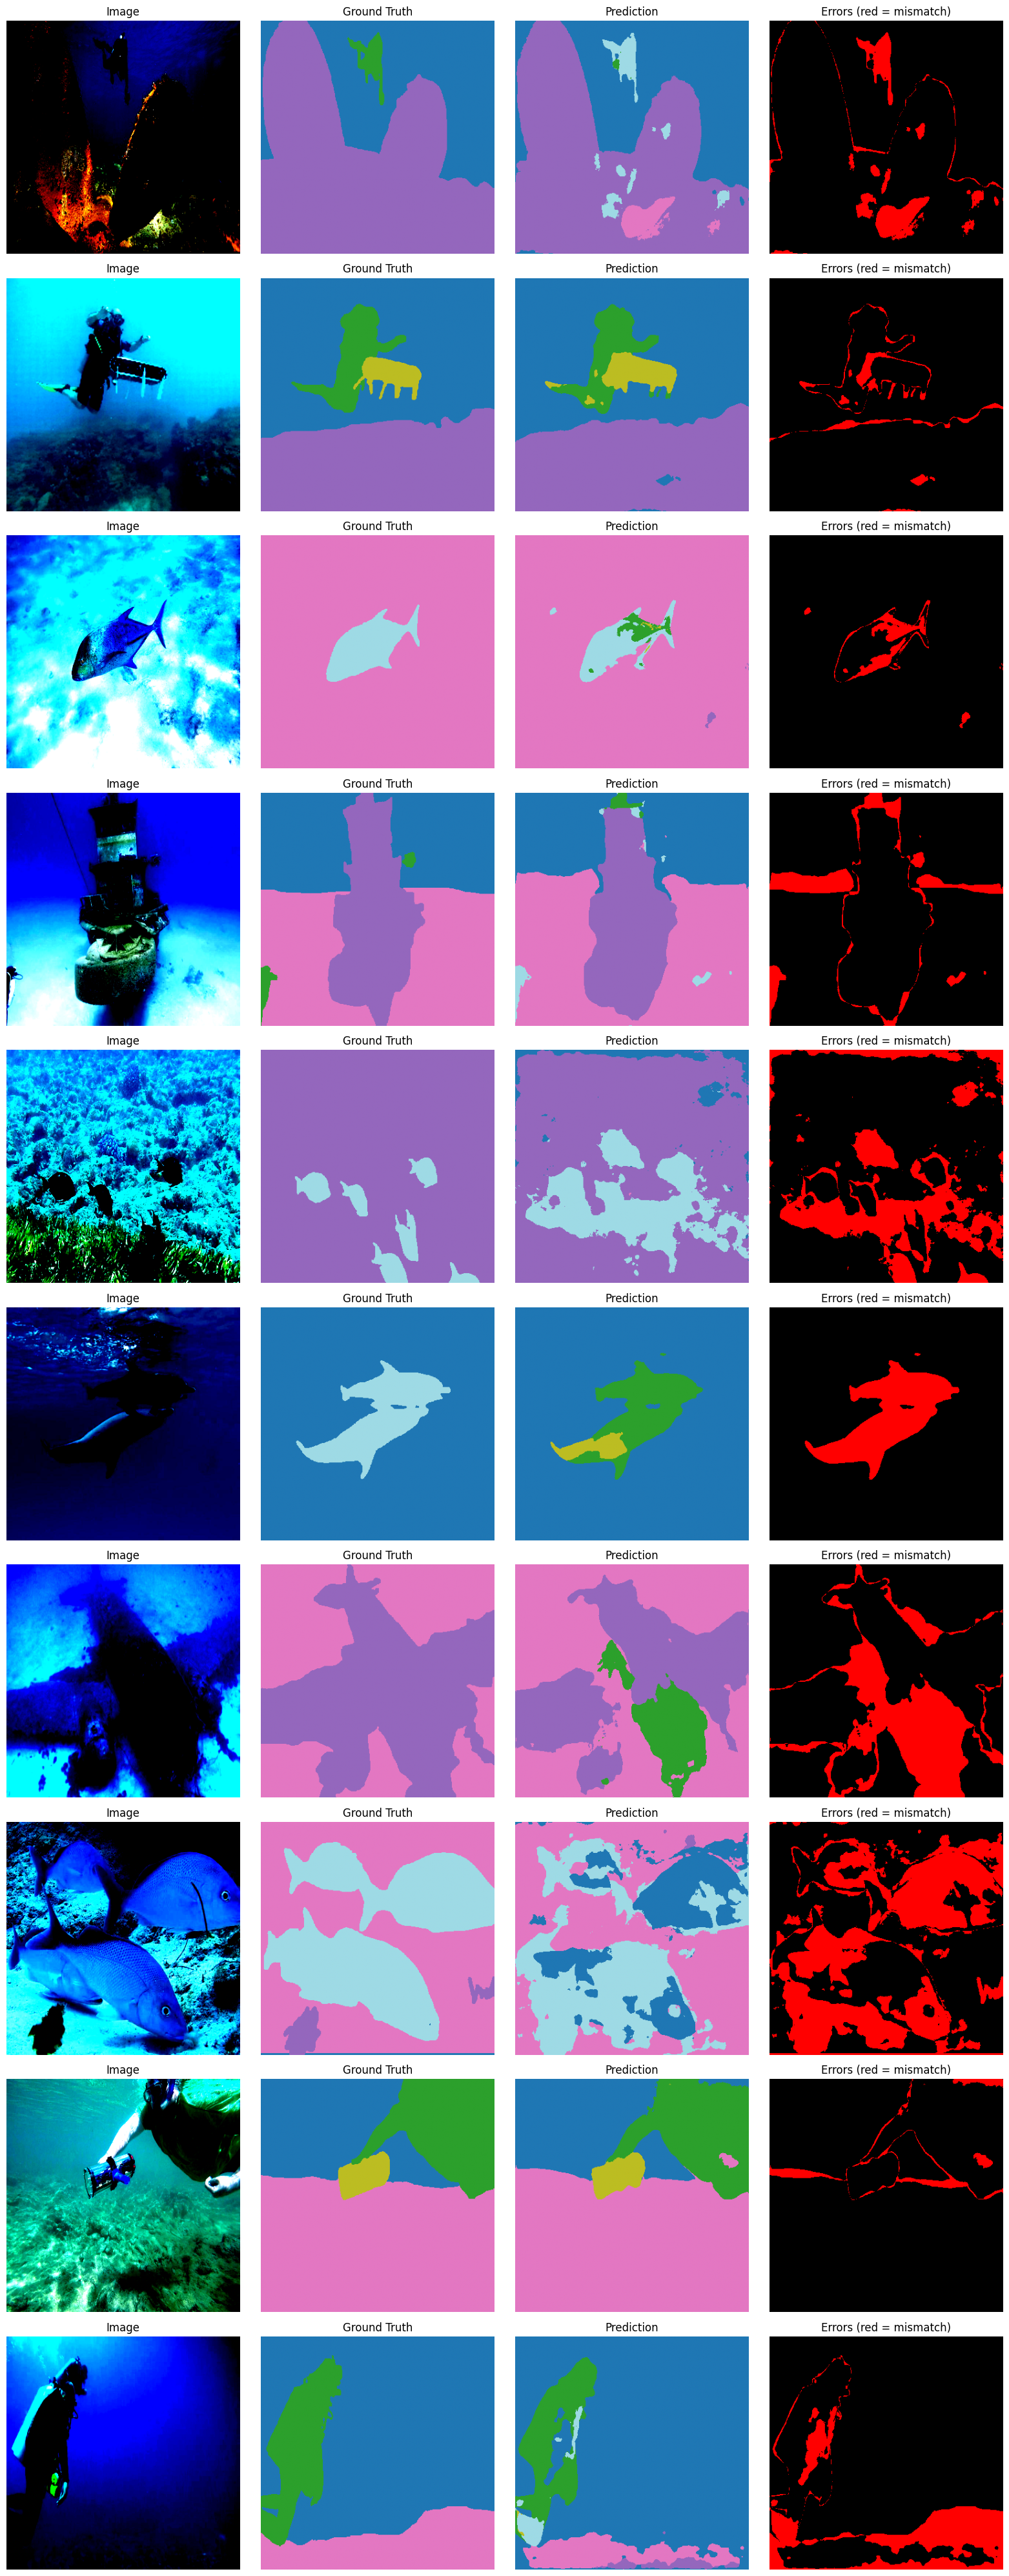

In [76]:
visualize_predictions_with_errors(
    model=model,
    dataset=val_dataset,
    device=device,
    num_samples=10,
    num_classes=6
)
